In [1]:
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import json
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
with open("../stock_data/stock-num_id.json",'r', encoding='UTF-8') as f:
    stock_id = json.load(f)

In [3]:
features = ['Capitalization', 'CirculatingCap','CirculatingMarketCap', 'MarketCap', 'PBRatio', 'PCFRatio', 'PSRatio','PeRatio', 'PeRatioLYR', 'TurnoverRatio']

In [4]:
Cash = 10000000 # allocation = 1000w
largeCap_portfolio = {} # 大市值公司的仓位
smallCap_portfolio = {} # 小市值公司的仓位
portfolio_capacity = 15 # portfolio中的个股个数
largeCap_Account = {} # 每一期期末——调仓前一天largeCap_portfolio中的个股价值（持有量*当日收盘价）
smallCap_Account = {} # 每一期期末——调仓前一天smallCap_portfolio中的个股价值（持有量*当日收盘价）
total_Account = {} # 每一期期末——调仓前一天的账户总价值（Cash + largeCap_Account + smallCap_Account）
Cap_leverage = 0.5 # 资金的0.2流向大市值公司，剩下的0.8流向小市值公司
vol_rate = 0.0001 # 考虑冲击成本，回测时每次调仓的成交量应小于当日该个股总成交量的0.0001倍
tax_rate = 0.0014 # 交易费用按交易金额的0.14%处理
#tax_rate = 0

In [5]:
price = pd.read_pickle("../stock_data/stock_price_standard_")

In [6]:
xgb_model = []
for i in range(7):
    xgb_clf = xgb.Booster()
    xgb_clf.load_model(f"../model/model_set/xgb-{2010+i}-{2014+i}.json")
    xgb_model.append(xgb_clf)

In [7]:
M_start_date = [
'2010-01-04',
'2010-02-01',
'2010-03-01',
'2010-04-01',
'2010-05-04',
'2010-06-01',
'2010-07-01',
'2010-08-02',
'2010-09-01',
'2010-10-08',
'2010-11-01',
'2010-12-01',
'2011-01-04',
'2011-02-01',
'2011-03-01',
'2011-04-01',
'2011-05-03',
'2011-06-01',
'2011-07-01',
'2011-08-01',
'2011-09-01',
'2011-10-10',
'2011-11-01',
'2011-12-01',
'2012-01-04',
'2012-02-01',
'2012-03-01',
'2012-04-05',
'2012-05-02',
'2012-06-01',
'2012-07-02',
'2012-08-01',
'2012-09-03',
'2012-10-08',
'2012-11-01',
'2012-12-03',
'2013-01-04',
'2013-02-01',
'2013-03-01',
'2013-04-01',
'2013-05-02',
'2013-06-03',
'2013-07-01',
'2013-08-01',
'2013-09-02',
'2013-10-08',
'2013-11-01',
'2013-12-02',
'2014-01-02',
'2014-02-07',
'2014-03-03',
'2014-04-01',
'2014-05-05',
'2014-06-03',
'2014-07-01',
'2014-08-01',
'2014-09-01',
'2014-10-08',
'2014-11-03',
'2014-12-01',
'2015-01-05',
'2015-02-02',
'2015-03-02',
'2015-04-01',
'2015-05-04',
'2015-06-01',
'2015-07-01',
'2015-08-03',
'2015-09-01',
'2015-10-08',
'2015-11-02',
'2015-12-01',
'2016-01-04',
'2016-02-01',
'2016-03-01',
'2016-04-01',
'2016-05-03',
'2016-06-01',
'2016-07-01',
'2016-08-01',
'2016-09-01',
'2016-10-10',
'2016-11-01',
'2016-12-01',
'2017-01-03',
'2017-02-03',
'2017-03-01',
'2017-04-05',
'2017-05-02',
'2017-06-01',
'2017-07-03',
'2017-08-01',
'2017-09-01',
'2017-10-09',
'2017-11-01',
'2017-12-01',
'2018-01-02',
'2018-02-01',
'2018-03-01',
'2018-04-02',
'2018-05-02',
'2018-06-01',
'2018-07-02',
'2018-08-01',
'2018-09-03',
'2018-10-08',
'2018-11-01',
'2018-12-03',
'2019-01-02',
'2019-02-01',
'2019-03-01',
'2019-04-01',
'2019-05-06',
'2019-06-03',
'2019-07-01',
'2019-08-01',
'2019-09-02',
'2019-10-08',
'2019-11-01',
'2019-12-02',
'2020-01-02',
'2020-02-03',
'2020-03-02',
'2020-04-01',
'2020-05-06',
'2020-06-01',
'2020-07-01',
'2020-08-03',
'2020-09-01',
'2020-10-09',
'2020-11-02',
'2020-12-01',
'2021-01-04',
'2021-02-01',
'2021-03-01',
'2021-04-01',
'2021-05-06',
'2021-06-01',
'2021-07-01',
'2021-08-02',
'2021-09-01',
'2021-10-08',
'2021-11-01',
'2021-12-01',
'2022-01-04']

In [8]:
M_end_date = [
'2010-01-29',
'2010-02-26',
'2010-03-31',
'2010-04-30',
'2010-05-31',
'2010-06-30',
'2010-07-30',
'2010-08-31',
'2010-09-30',
'2010-10-29',
'2010-11-30',
'2010-12-31',
'2011-01-31',
'2011-02-28',
'2011-03-31',
'2011-04-29',
'2011-05-31',
'2011-06-30',
'2011-07-29',
'2011-08-31',
'2011-09-30',
'2011-10-31',
'2011-11-30',
'2011-12-30',
'2012-01-31',
'2012-02-29',
'2012-03-30',
'2012-04-27',
'2012-05-31',
'2012-06-29',
'2012-07-31',
'2012-08-31',
'2012-09-28',
'2012-10-31',
'2012-11-30',
'2012-12-31',
'2013-01-31',
'2013-02-28',
'2013-03-29',
'2013-04-26',
'2013-05-31',
'2013-06-28',
'2013-07-31',
'2013-08-30',
'2013-09-30',
'2013-10-31',
'2013-11-29',
'2013-12-31',
'2014-01-30',
'2014-02-28',
'2014-03-31',
'2014-04-30',
'2014-05-30',
'2014-06-30',
'2014-07-31',
'2014-08-29',
'2014-09-30',
'2014-10-31',
'2014-11-28',
'2014-12-31',
'2015-01-30',
'2015-02-27',
'2015-03-31',
'2015-04-30',
'2015-05-29',
'2015-06-30',
'2015-07-31',
'2015-08-31',
'2015-09-30',
'2015-10-30',
'2015-11-30',
'2015-12-31',
'2016-01-29',
'2016-02-29',
'2016-03-31',
'2016-04-29',
'2016-05-31',
'2016-06-30',
'2016-07-29',
'2016-08-31',
'2016-09-30',
'2016-10-31',
'2016-11-30',
'2016-12-30',
'2017-01-26',
'2017-02-28',
'2017-03-31',
'2017-04-28',
'2017-05-31',
'2017-06-30',
'2017-07-31',
'2017-08-31',
'2017-09-29',
'2017-10-31',
'2017-11-30',
'2017-12-29',
'2018-01-31',
'2018-02-28',
'2018-03-30',
'2018-04-27',
'2018-05-31',
'2018-06-29',
'2018-07-31',
'2018-08-31',
'2018-09-28',
'2018-10-31',
'2018-11-30',
'2018-12-28',
'2019-01-31',
'2019-02-28',
'2019-03-29',
'2019-04-30',
'2019-05-31',
'2019-06-28',
'2019-07-31',
'2019-08-30',
'2019-09-30',
'2019-10-31',
'2019-11-29',
'2019-12-31',
'2020-01-23',
'2020-02-28',
'2020-03-31',
'2020-04-30',
'2020-05-29',
'2020-06-30',
'2020-07-31',
'2020-08-31',
'2020-09-30',
'2020-10-30',
'2020-11-30',
'2020-12-31',
'2021-01-29',
'2021-02-26',
'2021-03-31',
'2021-04-30',
'2021-05-31',
'2021-06-30',
'2021-07-30',
'2021-08-31',
'2021-09-30',
'2021-10-29',
'2021-11-30',
'2021-12-31',
'2022-01-28']

In [9]:
M_ = [x[:7] for x in M_start_date] 
start_map = dict(zip(M_, M_start_date))
end_map = dict(zip(M_, M_end_date))

In [10]:
model_map = {}
for i in range(6):
    for j in range(12):
        model_map[M_[60+i*12+j]] = xgb_model[i]
for i in range(13):
    model_map[M_[132+i]]=xgb_model[6]

2015年1月第一次建仓，此后七年的时间里分别用滚动训练的7个模型进行预测，调仓

In [11]:
def generate_signal(mon_date, clf)->(list, list):
    '''
    + 传入之前训练好的模型,在每月末(最后一个交易日)依据个股的features预测其下个月的超额收益率水平: rf_Rank从高到低依次为 2(超额收益率最高的30%), 1(其他), 0(超额收益率最低的30%)
    + 选出rf_rank==2, 即超额收益最高的30%支股票, 并按市值大小进行排序, 在大市值股票和小市值股票中各选出portfolio_capacity支, 返回这些股票的num_id
    '''
    backtest_data = pd.read_csv(f"../stock_data/train_data/{mon_date[:4]}.csv")
    backtest_data = backtest_data[backtest_data["time"] == mon_date]
    X_backtest = backtest_data[features]
    Dbacktest = xgb.DMatrix(X_backtest, feature_names=features)
    y_pred = clf.predict(Dbacktest)
    backtest_data["predict_rank"] = list(y_pred)
    largeCap_long = list(backtest_data[backtest_data["predict_rank"]==2].sort_values(by = "Capitalization")[:portfolio_capacity]["num_id"])
    smallCap_long = list(backtest_data[backtest_data["predict_rank"]==2].sort_values(by = "Capitalization")[-portfolio_capacity:]["num_id"])
    return largeCap_long, smallCap_long

def Short(short_date, largeCap_long, smallCap_long, remain_Cash)->(list, list, float):
    '''
    + 根据调仓信号，先进行平仓
    + 对于持仓中不在generate_signal函数给出的largeCap_long, smallCap_long的个股, 在月初(第一个交易日)全部平仓, 对于在其中的个股, 则继续持仓
    + 平仓后, 返回仍需要建仓的股票num_id, 以及平仓后的账户现金
    '''
    #平仓
    largeCap_long_removeList = []
    largeCap_portfolio_removeList = []
    for item in largeCap_portfolio: # 遍历largeCap持仓
        flag = 0
        for stock_to_long in largeCap_long:
            if item == str(stock_to_long): # 如果想要加仓的个股已经在portfolio内，则继续持有
                largeCap_long_removeList.append(stock_to_long)
                flag = 1
                break
        if not flag: # 如果现持有的某个股不在此次调仓的加仓信号中，则全部卖出
            revenue = largeCap_portfolio[item][0]*price.loc[stock_id[item], start_map[short_date]]["Open"]*100*(1-tax_rate)
            largeCap_portfolio_removeList.append(item)
            remain_Cash += round(revenue, 3)
    for llr in largeCap_long_removeList:
        largeCap_long.remove(llr)
    for lpr in largeCap_portfolio_removeList:
        largeCap_portfolio.pop(lpr)

    smallCap_long_removeList = []
    smallCap_portfolio_removeList = []
    for item in smallCap_portfolio: # 遍历smallCap持仓
        flag = 0
        for stock_to_long in smallCap_long:
            if item == str(stock_to_long): # 如果想要加仓的个股已经在portfolio内，则继续持有
                smallCap_long_removeList.append(stock_to_long)
                flag = 1
                break
        if not flag: # 如果现持有的某个股不在此次调仓的加仓信号中，则全部卖出
            revenue = smallCap_portfolio[item][0]*price.loc[stock_id[item], start_map[short_date]]["Open"]*100*(1-tax_rate)
            smallCap_portfolio_removeList.append(item)
            remain_Cash += round(revenue, 3)
    for slr in smallCap_long_removeList:
        smallCap_long.remove(slr)
    for spr in smallCap_portfolio_removeList:
        smallCap_portfolio.pop(spr)

    return largeCap_long, smallCap_long, remain_Cash

def Long(long_date, smallCap_long, largeCap_long, remain_Cash)->float:
    '''
    + 平仓后进行建仓, 买入Short函数返回的需要建仓的个股(设其中小市值股票m支, 大市值股票n支)
    + 建仓时, 将账户现金的(1-Cap_leverage)部分均分到m个小市值个股上. 建仓时为了规避冲击成本, 成交量应不大于当日该个股总成交量的vol_rate倍, 此外交易时还应考虑交易成本tax_rate
    + 小市值股票建仓完毕后, 将账户中剩下的现金均分到n个大市值股票上, 同样限制成交量且考虑交易成本
    + 由于之前的操作中没有判断这些个股是否能交易, 因此存在调仓日某支个股price==nan的情况(即无法交易), 因此使用try:... except:... 来应对
    + 部分个股在调仓日无法交易导致Long函数结束后账户现金并不为0
    '''
    # 买入rank为2的大市值公司和小市值公司各15股，不在这个范围之内的则平仓
    # 除非受val_rate的限制，否则分配在各大市值公司上的cash相同，分配在各小市值公司上的cash也相同
    Cash_for_smallCap = (remain_Cash * (1 - Cap_leverage))/len(smallCap_long)

    for stock in smallCap_long:
        # 交易单位为手（100股）
        try:
            long_vol = min(int(Cash_for_smallCap/price.loc[stock_id[str(stock)], start_map[long_date]]["Open"]*0.01), int(price.loc[stock_id[str(stock)], start_map[long_date]]["Volume"]*vol_rate))
            # long_vol: 需要买多少股（本地数据中volumes单位为手）
            if long_vol > 0:
                cost = round(price.loc[stock_id[str(stock)], start_map[long_date]]["Open"]*long_vol*100*(1+tax_rate), 3)
                remain_Cash -= cost
                smallCap_portfolio[str(stock)] = (long_vol, cost) 
        except: # 可能有的个股在调仓日没有交易，price为nan
            continue

    Cash_for_largeCap = remain_Cash /len(largeCap_long)
    for stock in largeCap_long:
        try:
            long_vol = min(int(Cash_for_largeCap /price.loc[stock_id[str(stock)], start_map[long_date]]["Open"]*0.01), int(price.loc[stock_id[str(stock)], start_map[long_date]]["Volume"]*vol_rate))
            # long_vol: 需要买多少股（本地数据中volumes单位为手）
            if long_vol > 0:
                cost = round(price.loc[stock_id[str(stock)], start_map[long_date]]["Open"]*long_vol*100*(1+tax_rate), 3)
                remain_Cash -= cost
                largeCap_portfolio[str(stock)] = (long_vol, cost) 
        except: # 可能有的个股在调仓日没有交易，price为nan
            continue

    return remain_Cash

def Accounting(mon_date)->None:
    '''
    + 计算每个月月末账户价值, 包括: 大市值portfolio的价值(持仓量*月末交易日的收盘价), 小市值portfolio的价值(持仓量*月末交易日的收盘价), 账户总价值(前两项+剩余现金)
    + 将这些数值存入全局对象largeCap_Account, smallCap_Account, total_Account中, 以便绘图和观测
    '''
    largeCap_value = 0
    smallCap_value = 0
    for item in largeCap_portfolio:
        largeCap_value += largeCap_portfolio[item][0]*price.loc[stock_id[item], end_map[mon_date]]["Close"]*100
    for item in smallCap_portfolio:
        smallCap_value += smallCap_portfolio[item][0]*price.loc[stock_id[item], end_map[mon_date]]["Close"]*100
    largeCap_Account[mon_date] = round(largeCap_value,3)
    smallCap_Account[mon_date] = round(smallCap_value,3)
    total_Account[mon_date] = round(largeCap_value + smallCap_value + Cash, 3)

In [12]:
order = pd.DataFrame(columns=["trading_date", "stock", "type", "price", "volume"])

In [13]:

order.loc[len(order.index)] = [1, 2, 3, 4, 5]

In [14]:
stock_id

{'1': 'S.CN.SSE.600881',
 '2': 'S.CN.SSE.688065',
 '3': 'S.CN.SZSE.002281',
 '4': 'S.CN.SZSE.300347',
 '5': 'S.CN.SZSE.000807',
 '6': 'S.CN.SSE.600825',
 '7': 'S.CN.SSE.601008',
 '8': 'S.CN.SZSE.000422',
 '9': 'S.CN.SZSE.002901',
 '10': 'S.CN.SSE.600074',
 '11': 'S.CN.SSE.600744',
 '12': 'S.CN.SSE.600312',
 '13': 'S.CN.SZSE.002203',
 '14': 'S.CN.SSE.603638',
 '15': 'S.CN.SZSE.000723',
 '16': 'S.CN.SSE.600621',
 '17': 'S.CN.SZSE.000905',
 '18': 'S.CN.SZSE.000417',
 '19': 'S.CN.SZSE.002482',
 '20': 'S.CN.SZSE.300012',
 '21': 'S.CN.SZSE.001203',
 '22': 'S.CN.SZSE.002430',
 '23': 'S.CN.SZSE.002544',
 '24': 'S.CN.SZSE.002344',
 '25': 'S.CN.SSE.600566',
 '26': 'S.CN.SZSE.000537',
 '27': 'S.CN.SSE.600861',
 '28': 'S.CN.SZSE.002048',
 '29': 'S.CN.SSE.600199',
 '30': 'S.CN.SSE.600871',
 '31': 'S.CN.SZSE.000078',
 '32': 'S.CN.SZSE.002359',
 '33': 'S.CN.SZSE.002085',
 '34': 'S.CN.SZSE.000099',
 '35': 'S.CN.SSE.688188',
 '36': 'S.CN.SSE.603712',
 '37': 'S.CN.SZSE.000589',
 '38': 'S.CN.SSE.600125',

In [15]:
def record(mon_date, num_id, _type, price, volume):
    order.loc[len(order.index)] = [mon_date, stock_id[num_id], _type, price, volume]


In [16]:
Cash

10000000

In [17]:
M_[60]

'2015-01'

In [18]:
M_[60:][3]

'2015-04'

In [19]:
model_map["2014-12"] = xgb_model[0]
Accounting(M_[60])
for rank in range(len(M_[60:-1])):
    large_set, small_set = generate_signal(M_[60:][rank], xgb_model[0])
    large_set, small_set, Cash = Short(M_[60:][rank+1], large_set, small_set, Cash)
    Cash = Long(M_[60:][rank+1], large_set, small_set, Cash)
    Accounting(M_[60:][rank+1])


In [20]:
Cash

120634.40900000033

In [21]:
largeCap_Account

{'2015-01': 0,
 '2015-02': 5705887.944,
 '2015-03': 6500548.025,
 '2015-04': 5227621.954,
 '2015-05': 7368062.008,
 '2015-06': 5735331.981,
 '2015-07': 4257786.02,
 '2015-08': 4468296.935,
 '2015-09': 3628928.031,
 '2015-10': 5726586.971,
 '2015-11': 6850446.008,
 '2015-12': 6607028.922,
 '2016-01': 3633126.988,
 '2016-02': 4548079.956,
 '2016-03': 6625817.023,
 '2016-04': 4898811.984,
 '2016-05': 4822728.957,
 '2016-06': 5253144.049,
 '2016-07': 3567588.992,
 '2016-08': 5369345.933,
 '2016-09': 4482315.056,
 '2016-10': 4944828.017,
 '2016-11': 5108354.957,
 '2016-12': 5351019.109,
 '2017-01': 5034229.948,
 '2017-02': 3637337.985,
 '2017-03': 5218781.92,
 '2017-04': 5035232.937,
 '2017-05': 4793113.957,
 '2017-06': 4588320.031,
 '2017-07': 4326556.968,
 '2017-08': 4415591.918,
 '2017-09': 5030164.927,
 '2017-10': 4415559.922,
 '2017-11': 4153135.933,
 '2017-12': 4826748.048,
 '2018-01': 4077598.008,
 '2018-02': 3748735.988,
 '2018-03': 3700075.005,
 '2018-04': 3652822.974,
 '2018-05': 

In [22]:
smallCap_Account

{'2015-01': 0,
 '2015-02': 3605344.046,
 '2015-03': 4734930.044,
 '2015-04': 6589029.048,
 '2015-05': 5595805.975,
 '2015-06': 5280962.031,
 '2015-07': 4532699.061,
 '2015-08': 3893075.946,
 '2015-09': 4301922.004,
 '2015-10': 5179303.996,
 '2015-11': 4129247.019,
 '2015-12': 6362493.925,
 '2016-01': 4715503.993,
 '2016-02': 4176970.018,
 '2016-03': 4813936.985,
 '2016-04': 5066661.989,
 '2016-05': 5052153.975,
 '2016-06': 5385990.997,
 '2016-07': 5631430.992,
 '2016-08': 5184041.025,
 '2016-09': 5258749.006,
 '2016-10': 5442032.957,
 '2016-11': 5958425.016,
 '2016-12': 4426206.021,
 '2017-01': 5215552.994,
 '2017-02': 4444259.994,
 '2017-03': 4833150.987,
 '2017-04': 5472243.051,
 '2017-05': 4201063.004,
 '2017-06': 4577867.013,
 '2017-07': 5140895.964,
 '2017-08': 5269560.975,
 '2017-09': 5076014.999,
 '2017-10': 4735457.065,
 '2017-11': 4490791.985,
 '2017-12': 3321613.995,
 '2018-01': 4612139.054,
 '2018-02': 4222608.999,
 '2018-03': 4243334.017,
 '2018-04': 4029454.979,
 '2018-05'

In [23]:
total_Account

{'2015-01': 10000000,
 '2015-02': 10707560.652,
 '2015-03': 12570754.393,
 '2015-04': 14026737.062,
 '2015-05': 14632397.119,
 '2015-06': 13751982.814,
 '2015-07': 11592839.66,
 '2015-08': 10196337.63,
 '2015-09': 9849064.808,
 '2015-10': 11677342.013,
 '2015-11': 12498751.246,
 '2015-12': 13415572.835,
 '2016-01': 10251237.38,
 '2016-02': 10302832.773,
 '2016-03': 11848721.025,
 '2016-04': 11418646.901,
 '2016-05': 11091989.811,
 '2016-06': 11090202.039,
 '2016-07': 11113576.505,
 '2016-08': 11359470.694,
 '2016-09': 11406906.977,
 '2016-10': 11669632.236,
 '2016-11': 11847526.231,
 '2016-12': 11357793.117,
 '2017-01': 11156177.129,
 '2017-02': 11513883.628,
 '2017-03': 11296124.272,
 '2017-04': 10934839.432,
 '2017-05': 9861411.942,
 '2017-06': 10124620.234,
 '2017-07': 10354283.289,
 '2017-08': 10705677.046,
 '2017-09': 10482167.937,
 '2017-10': 10208300.511,
 '2017-11': 9832079.658,
 '2017-12': 9872646.093,
 '2018-01': 9679901.211,
 '2018-02': 9169713.671,
 '2018-03': 9315458.671,


In [24]:
hs300 = pd.read_csv("../stock_data/hs300.csv")

In [25]:
hs300_Open_price = pd.DataFrame(columns=hs300.columns)
hs300_Close_price = pd.DataFrame(columns=hs300.columns)

In [26]:
for date in M_start_date:
    hs300_Open_price = hs300_Open_price.append(hs300[hs300["Unnamed: 0"]==date])
for date in M_end_date:
    hs300_Close_price = hs300_Close_price.append(hs300[hs300["Unnamed: 0"]==date])

In [27]:
hs300_Close_price

,Unnamed: 0,open,close,high,low,volume,money
19,2010-01-29,3190.32,3204.16,3249.45,3176.92,5.026261e+09,6.801812e+10
34,2010-02-26,3286.09,3281.67,3301.15,3273.69,5.210729e+09,7.017167e+10
57,2010-03-31,3369.19,3345.61,3369.90,3338.74,5.312429e+09,7.212089e+10
78,2010-04-30,3060.12,3067.36,3068.13,3014.07,5.447788e+09,7.319088e+10
98,2010-05-31,2835.33,2773.26,2857.42,2772.79,4.621685e+09,5.669580e+10
...,...,...,...,...,...,...,...
2855,2021-09-30,4843.95,4866.38,4876.07,4843.95,1.461139e+10,2.832547e+11
2871,2021-10-29,4861.27,4908.77,4908.77,4855.76,1.598874e+10,3.687320e+11
2893,2021-11-30,4857.18,4832.03,4871.25,4810.22,1.296306e+10,2.792682e+11
2916,2021-12-31,4937.46,4940.37,4950.36,4923.14,1.213137e+10,2.669754e+11


In [28]:
hs300

,Unnamed: 0,open,close,high,low,volume,money
0,2010-01-04,3592.47,3535.23,3597.75,3535.23,6.610108e+09,9.341984e+10
1,2010-01-05,3545.19,3564.04,3577.53,3497.66,8.580964e+09,1.283024e+11
2,2010-01-06,3558.70,3541.73,3588.83,3541.17,7.847312e+09,1.210460e+11
3,2010-01-07,3543.16,3471.46,3558.56,3452.77,8.035004e+09,1.204362e+11
4,2010-01-08,3456.91,3480.13,3482.08,3426.70,6.079025e+09,9.019096e+10
...,...,...,...,...,...,...,...
2936,2022-02-07,4638.58,4634.09,4672.65,4615.01,1.448497e+10,2.660318e+11
2937,2022-02-08,4626.44,4608.77,4626.44,4522.47,1.558307e+10,2.813649e+11
2938,2022-02-09,4608.15,4652.06,4659.46,4595.28,1.483355e+10,2.737720e+11
2939,2022-02-10,4657.21,4639.86,4657.21,4608.09,1.515767e+10,2.872244e+11


In [29]:
# 第一期买入尽可能多的沪深三百，之后每一期调仓时，都将利用剩余的现金继续尽可能多的买入沪深三百
hs300_Account_baseline = 10000000
hs300_total_Account = {}
hs300_total_vol = 0
for date in M_[60:]:
    max_vol = int(hs300_Account_baseline / list(hs300[hs300["Unnamed: 0"]==start_map[date]]["open"])[0])
    hs300_total_vol += max_vol
    hs300_Account_baseline -= max_vol * list(hs300[hs300["Unnamed: 0"]==start_map[date]]["open"])[0]*(1+tax_rate)
    hs300_total_Account[date] = round(hs300_Account_baseline + hs300_total_vol*list(hs300[hs300["Unnamed: 0"]==end_map[date]]["close"])[0], 3)
    


In [30]:
hs300_total_Account

{'2015-01': 9616714.157,
 '2015-02': 10004304.12,
 '2015-03': 11344190.48,
 '2015-04': 13301221.17,
 '2015-05': 13555944.11,
 '2015-06': 12525652.28,
 '2015-07': 10687355.98,
 '2015-08': 9426457.82,
 '2015-09': 8968242.23,
 '2015-10': 9895737.36,
 '2015-11': 9986293.69,
 '2015-12': 10447338.29,
 '2016-01': 8248777.37,
 '2016-02': 8056638.435,
 '2016-03': 9010374.435,
 '2016-04': 8838622.435,
 '2016-05': 8874490.435,
 '2016-06': 8830698.435,
 '2016-07': 8970726.435,
 '2016-08': 9317534.435,
 '2016-09': 9108906.435,
 '2016-10': 9341306.435,
 '2016-11': 9906122.435,
 '2016-12': 9267946.435,
 '2017-01': 9486010.435,
 '2017-02': 9667590.435,
 '2017-03': 9676662.435,
 '2017-04': 9631022.435,
 '2017-05': 9779786.435,
 '2017-06': 10266762.435,
 '2017-07': 10465758.435,
 '2017-08': 10701574.435,
 '2017-09': 10741922.435,
 '2017-10': 11218538.435,
 '2017-11': 11216802.435,
 '2017-12': 11286102.435,
 '2018-01': 11972242.435,
 '2018-02': 11265914.435,
 '2018-03': 10915522.435,
 '2018-04': 10518986

In [31]:
x_date = M_[60:]
y_large_account = largeCap_Account.values()
y_small_account = smallCap_Account.values()
y_total_account = total_Account.values()
y_baseline = hs300_total_Account.values()

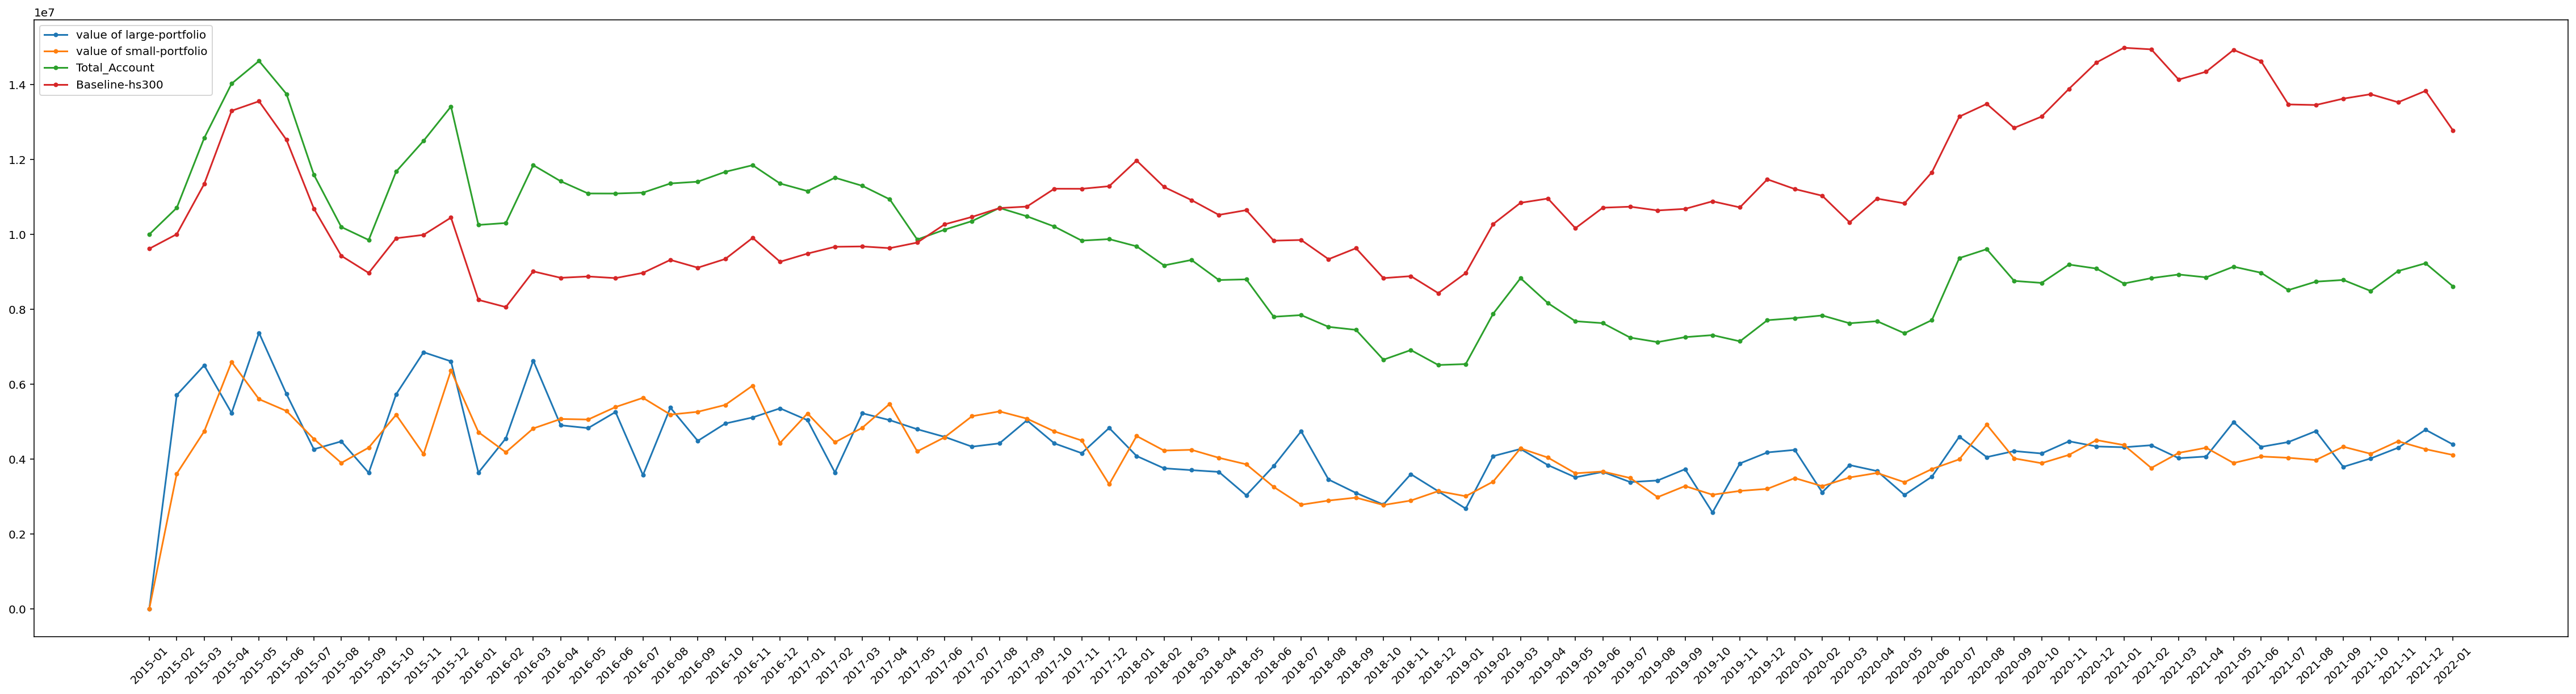

In [32]:
plt.figure(figsize=(40, 10))
plt.xticks(rotation=45)
plt.plot(x_date, y_large_account, marker='o', markersize=3)  # 绘制折线图，添加数据点，设置点的大小
plt.plot(x_date, y_small_account, marker='o', markersize=3)
plt.plot(x_date, y_total_account, marker='o', markersize=3)
plt.plot(x_date, y_baseline, marker='o', markersize=3)
plt.legend([ 'value of large-portfolio','value of small-portfolio', 'Total_Account', 'Baseline-hs300'])  # 设置折线名称
plt.savefig("backtest.png")